# Часть 0

Возьмём датасет CelebA-500 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.functional import pairwise_cosine_similarity
import torchvision
import torchvision.transforms as transforms
from torchvision import models

from PIL import Image
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

import os
from tqdm import tqdm

from IPython import display

import math

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
os.listdir('./../input/celeba-500/')

['celebA_train_500']

In [3]:
root = './../input/celeba-500/'
data_dir = root + 'celebA_train_500/'

split = {}
classes = {}
dataloader = {}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
with open(data_dir + 'celebA_train_split.txt', 'r') as file:
    for line in file:
        filename, number = line.split()

        split[filename] = int(number)

with open(data_dir + 'celebA_anno.txt', 'r') as file:
    for line in file:
        filename, attr = line.split()

        classes[filename] = int(attr)

In [5]:
split = pd.DataFrame.from_dict(split, orient='index', columns=['split'])
classes = pd.DataFrame.from_dict(classes, orient='index', columns=['class'])

In [6]:
def fetch_data(data_dir, split, classes):
    data = []
    for filename in tqdm(os.listdir(data_dir)):
        if filename in split.index:
            path = os.path.join(data_dir, filename)

            data.append({
                'path': path,
                'split': split.loc[filename, 'split'],
                'class': classes.loc[filename, 'class']
            })

    return pd.DataFrame.from_dict(data)

In [7]:
dataset = fetch_data(data_dir + 'celebA_imgs/', split, classes)

100%|██████████| 23948/23948 [00:00<00:00, 51026.67it/s]


In [8]:
dataset[:10]

,path,split,class
0,./../input/celeba-500/celebA_train_500/celebA_...,0,273
1,./../input/celeba-500/celebA_train_500/celebA_...,0,294
2,./../input/celeba-500/celebA_train_500/celebA_...,0,80
3,./../input/celeba-500/celebA_train_500/celebA_...,0,148
4,./../input/celeba-500/celebA_train_500/celebA_...,0,152
5,./../input/celeba-500/celebA_train_500/celebA_...,0,293
6,./../input/celeba-500/celebA_train_500/celebA_...,1,256
7,./../input/celeba-500/celebA_train_500/celebA_...,0,155
8,./../input/celeba-500/celebA_train_500/celebA_...,2,256
9,./../input/celeba-500/celebA_train_500/celebA_...,0,390


Распределение на train, val, test получается такое:

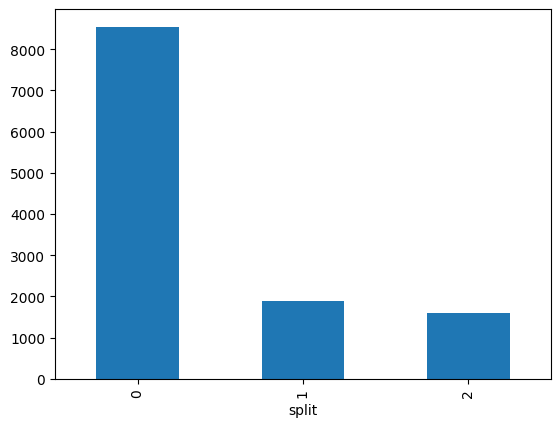

In [9]:
dataset['split'].value_counts().plot(kind='bar')
plt.show()

Пусть 
0 - train
1 - val
2 - test

In [10]:
train = dataset[dataset['split'] == 0][['path', 'class']].values
val = dataset[dataset['split'] == 1][['path', 'class']].values
test = dataset[dataset['split'] == 2][['path', 'class']].values

In [11]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [12]:
class CelebADataset(torch.utils.data.Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        path, label = self.data[index]
        image = np.array(Image.open(path))
        image = Image.fromarray(image[77:-41, 45:-50])
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [13]:
train = CelebADataset(train, transform)
val = CelebADataset(val, transform)
test = CelebADataset(test, transform)

In [14]:
dataloader['train'] = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
dataloader['val'] = torch.utils.data.DataLoader(val, batch_size=32, shuffle=True)
dataloader['test'] = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True)

# Часть 1

Для начала сделаем следующее: обучим сеть (в данном случае предобученную ResNet18) на классификацию тренировочных данных с CELoss

In [88]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
model.fc = torch.nn.Linear(model.fc.in_features, 500).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
epochs = 10

In [15]:
def plot_loss_acc(loss_train, loss_val, acc_train, acc_val):
    display.clear_output(wait=True)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(loss_train, label='train')
    plt.plot(loss_val, label='val')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(acc_train, label='train')
    plt.plot(acc_val, label='val')
    plt.legend()
    plt.title('Accuracy')

    plt.tight_layout()

    plt.show()

In [16]:
def train(model, criterion, optimizer, epochs, dataloader):
    loss_train = []
    loss_val = []
    
    acc_train = []
    acc_val = []
    
    for _ in tqdm(range(epochs)):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            acc = 0

            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloader[phase].dataset)

            if phase == 'train':
                loss_train.append(epoch_loss)
                acc_train.append(epoch_acc.item())
            else:
                loss_val.append(epoch_loss)
                acc_val.append(epoch_acc.item())

        plot_loss_acc(loss_train, loss_val, acc_train, acc_val)
    
    return loss_train, loss_val, acc_train, acc_val

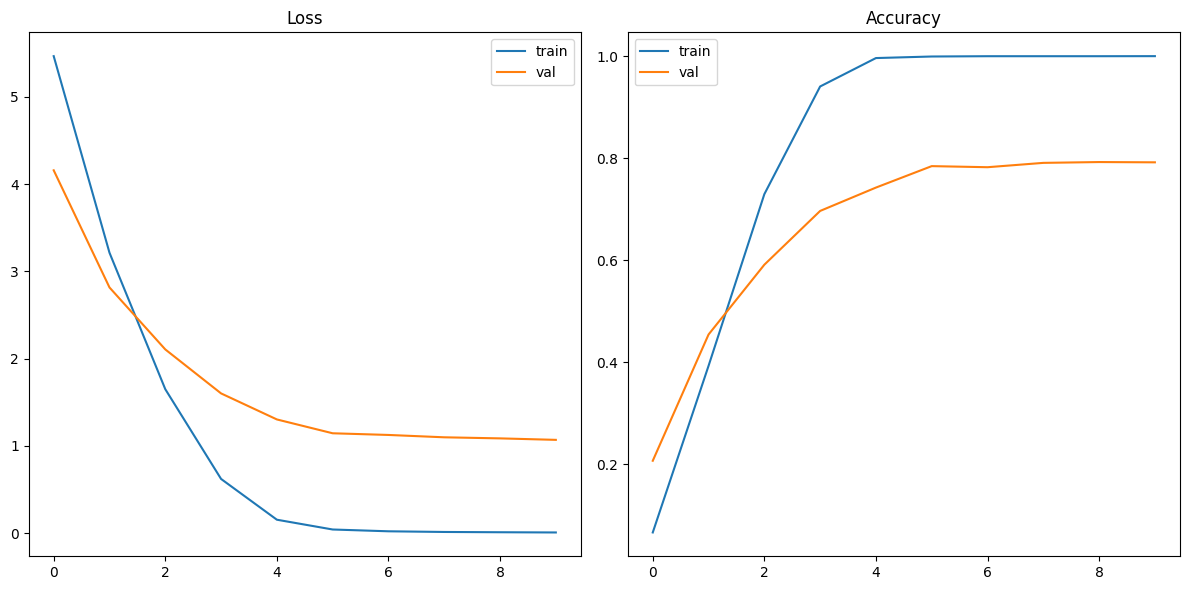

100%|██████████| 10/10 [09:28<00:00, 56.86s/it]


In [91]:
loss_train, loss_val, acc_train, acc_val = train(model, criterion, optimizer, epochs, dataloader)

Сначала протестируем качество классификации на тесте самым тупым способом - просто посчитаем accuracy:

In [17]:
def test(model, dataloader):
    model.eval()
    
    running_corrects = 0
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        
    acc = running_corrects.double() / len(dataloader.dataset)
    
    return acc.item()

In [93]:
test_acc = test(model, dataloader['test'])
test_acc

0.7967275015733166

In [94]:
torch.save(model.state_dict(), 'resnet18_celeba.pt')

# Часть 2

Теперь хотим посчитать метрику Identification Rate

Уберём последний слой (заменим на Identity)

In [98]:
model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, 500)
model.load_state_dict(torch.load('./../input/resnet/' + 'resnet18_celeba (1).pt'))
model.fc = nn.Identity()
model = model.to(device)

Загрузим дополнительные данные, которые не содержатся в обучающем датасете

In [27]:
from collections import defaultdict

# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('./../input/celeba-ir/celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
query_img_names = [x[0] for x in query_lines]

query_dict = defaultdict(list)
for img_name, img_class in query_lines:
    query_dict[img_class].append(img_name)

distractors_img_names = os.listdir('./../input/celeba-ir/celebA_ir/celebA_distractors')

In [28]:
def compute_embeddings(model, images_list, root):
    '''
    compute embeddings from the trained model for list of images.
    params:
        model: trained nn model that takes images and outputs embeddings
        images_list: list of images paths to compute embeddings for
    output:
        list: list of model embeddings. Each embedding corresponds to images
          names from images_list
    '''
    model.eval()
    embeddings = []

    for img_path in images_list:
        img = Image.open(root + img_path)
        img = img.convert('RGB')
        img = img.resize((224, 224))
        img = np.array(img)
        img = np.expand_dims(img, axis=0)
        img = np.float32(img)
        
        img = torch.from_numpy(img)
        img = img.to(device)
        img = img.permute(0, 3, 1, 2)
        
        with torch.set_grad_enabled(False):
            embedding = model(img)
            
        embedding = embedding.cpu()
        embedding = embedding.detach().numpy()
        embeddings.append(embedding)
    
    return embeddings

In [101]:
query_embeddings = compute_embeddings(model, query_img_names, './../input/celeba-ir/celebA_ir/celebA_query/')
distractors_embeddings = compute_embeddings(model, distractors_img_names, './../input/celeba-ir/celebA_ir/celebA_distractors/')

In [29]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between positive pairs from query (stage 1)
    params:
        query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
        query_img_names: list of images names
        query_embeddings: list of embeddings corresponding to query_img_names
    output:
        list of floats: similarities between embeddings corresponding
                    to the same people from query list
    '''
    cosine_similarities = []
    
    for img_class in query_dict:
        for i in range(len(query_dict[img_class])):
            for j in range(i + 1, len(query_dict[img_class])):
                emb_i = query_embeddings[query_img_names.index(query_dict[img_class][i])]
                emb_j = query_embeddings[query_img_names.index(query_dict[img_class][j])]
                cosine_similarities.append(np.sum(emb_i * emb_j) / (np.linalg.norm(emb_i) * np.linalg.norm(emb_j)))
                
    return cosine_similarities

In [30]:
def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between negative pairs from query (stage 2)
    params:
        query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                the dataset. Value: images corresponding to that class
        query_img_names: list of images names
        query_embeddings: list of embeddings corresponding to query_img_names
    output:
        list of floats: similarities between embeddings corresponding
                    to different people from query list
    '''
    cosine_similarities = []
    
    for class_1_idx in range(len(query_dict)):
        for class_2_idx in range(class_1_idx + 1, len(query_dict)):
            class_1 = list(query_dict.keys())[class_1_idx]
            class_2 = list(query_dict.keys())[class_2_idx]

            for i in range(len(query_dict[class_1])):
                for j in range(len(query_dict[class_2])):
                    emb_i = query_embeddings[query_img_names.index(query_dict[class_1][i])]
                    emb_j = query_embeddings[query_img_names.index(query_dict[class_2][j])]
                    cosine_similarities.append(np.sum(emb_i * emb_j) / (np.linalg.norm(emb_i) * np.linalg.norm(emb_j)))
                    
    return cosine_similarities

In [31]:
def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    '''
    compute cosine similarities between negative pairs from query and distractors
    (stage 3)
    params:
        query_embeddings: list of embeddings corresponding to query_img_names
        distractors_embeddings: list of embeddings corresponding to distractors_img_names
    output:
        list of floats: similarities between pairs of people (q, d), 
        where q - embedding corresponding to photo from query, 
              d — embedding corresponding to photo from distractors
    '''
    cosine_similarities = []
    
    for emb_q in query_embeddings:
        for emb_d in distractors_embeddings:
            cosine_similarities.append(np.sum(emb_q * emb_d) / (np.linalg.norm(emb_q) * np.linalg.norm(emb_d)))
            
    return cosine_similarities

In [105]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names, query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, distractors_embeddings)

Протестируем работоспособность функций

In [106]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = np.array([
                    np.array([1.56, 6.45,  -7.68]),
                    np.array([-1.1 , 6.11,  -3.0]),
                    np.array([-0.06,-0.98,-1.29]),
                    np.array([8.56, 1.45,  1.11]),
                    np.array([0.7,  1.1,   -7.56]),
                    np.array([0.05, 0.9,   -2.56]),
])

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    np.array([0.12, -3.23, -5.55]),
                    np.array([-1,   -0.01, 1.22]),
                    np.array([0.06, -0.23, 1.34]),
                    np.array([-6.6, 1.45,  -1.45]),
                    np.array([0.89,  1.98, 1.45]),
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names, test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names, test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings, test_distractors_embeddings)

In [107]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

print("All tests passed!")

All tests passed!


In [32]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=0.1):
    '''
    compute identification rate using precomputer cosine similarities between pairs at given fpr
    params:
        cosine_query_pos: cosine similarities between positive pairs from query
        cosine_query_neg: cosine similarities between negative pairs from query
        cosine_query_distractors: cosine similarities between negative pairs
                              from query and distractors
        fpr: false positive rate at which to compute TPR
    output:
        float: threshold for given fpr
        float: TPR at given FPR
    '''
    
    false_pairs = list(cosine_query_neg) + list(cosine_query_distractors)
    N = int((1 - fpr) * (len(false_pairs)))
    threshold = np.sort(np.array(false_pairs))[N]
    tpr = np.sum(np.array(cosine_query_pos) > threshold) / len(cosine_query_pos)
    return threshold, tpr

In [112]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
    x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg, test_cosine_query_distractors, fpr=fpr)
    test_thr.append(x)
    test_tpr.append(y)

In [113]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

print("All tests passed!")

All tests passed!


Итоговые результаты для обученной модели:

In [114]:
fprs = [0.5, 0.2, 0.1, 0.05]

for fpr in fprs:
    threshold, tpr = compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=fpr)
    print(f"Threshold = {threshold}, TPR = {tpr}")

Threshold = 0.9940853714942932, TPR = 0.6217648257591196
Threshold = 0.9971418976783752, TPR = 0.32959717410502004
Threshold = 0.9980658292770386, TPR = 0.2051491067182936
Threshold = 0.9986026287078857, TPR = 0.1274369947693771


# Часть 3

Теперь обучим сеть с ArcFaceLoss

Стандартные SoftMax + кросс-энтропия (CE) выглядят так:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

здесь:
- $x_i \in \mathbb{R^d}$ — вектор $i$-го элемента обучающей выборки перед последним полносвязным слоем сети. $y_i$ — класс этого элемента;
- $W_j \in \mathbb{R^d}$ — j-ый столбец матрицы весов последнего слоя сети (т.е. слоя, который производит итоговую классификацю входящего объекта);
- $b_j \in \mathbb{R^d}$ — j-ый элемент вектора байеса последнего слоя сети;
- $N$ — batch size;
- $n$ — количество классов.

Давайте теперь немного поправим формулу:
- уберем байес последнего слоя, т.е. сделаем $b_j=0$;
- нормализуем веса последнего слоя: ||$W_j$|| = 1;
- нормализуем эмбеддинги: ||$x_i$|| = 1. Перед подачей их на вход последнему слою (т.е. перед умножением на матрицу $W_j$) умножим их на гиперпараметр s.

Получается, в степени экспоненты у нас останется выражение $s W_{y_i}^{T}x_i$, которое можно переписать в виде  $s W_{y_i}^{T}x_i = s ||W_{y_i}||\cdot ||x_i|| \cdot cos\Theta_{y_i}$. Тут $\Theta_{y_i}$ — это угол между векторами $W_{y_i}$ и $x_i$. Но так как мы сделали нормы $W_{y_i}$ и $x_i$ единичными, то все это выражение просто будет равно $s cos\Theta_{y_i}$.

В итоге мы получим следующую формулу лосса:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$


И последний шаг. Добавим еще один гиперпараметр $m$.

В итоге получим вот что:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Я взял реализацию из 

In [18]:
def train_v2(model, criterion, optimizer, epochs, dataloader):
    loss_train = []
    loss_val = []
    
    acc_train = []
    acc_val = []
    
    for _ in tqdm(range(epochs)):
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            acc = 0

            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs, labels)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloader[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloader[phase].dataset)

            if phase == 'train':
                loss_train.append(epoch_loss)
                acc_train.append(epoch_acc.item())
            else:
                loss_val.append(epoch_loss)
                acc_val.append(epoch_acc.item())

        plot_loss_acc(loss_train, loss_val, acc_train, acc_val)
    
    return loss_train, loss_val, acc_train, acc_val

In [19]:
class ArcFace(nn.Module):
    def __init__(self, in_features, out_features, s=64.0, m=0.5):
        super(ArcFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        # --------------------------- cos(theta) & phi(theta) ---------------------
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)
            
        # --------------------------- convert label to one-hot ---------------------
        # one_hot = torch.zeros(cosine.size(), requires_grad=True, device='cuda')
        one_hot = torch.zeros(cosine.size(), device=device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        # -------------torch.where(out_i = {x_i if condition_i else y_i) ------------
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

In [20]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, 500).to(device)
        self.arcface = ArcFace(500, 500, s=5, m=0.5).to(device)

    def forward(self, x, labels=None):
        x = self.model(x)
        if labels is not None:
            x = self.arcface(x, labels)
        return x    

In [63]:
model_v2 = MyModel()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_v2.parameters(), lr=3e-4)

epochs = 80

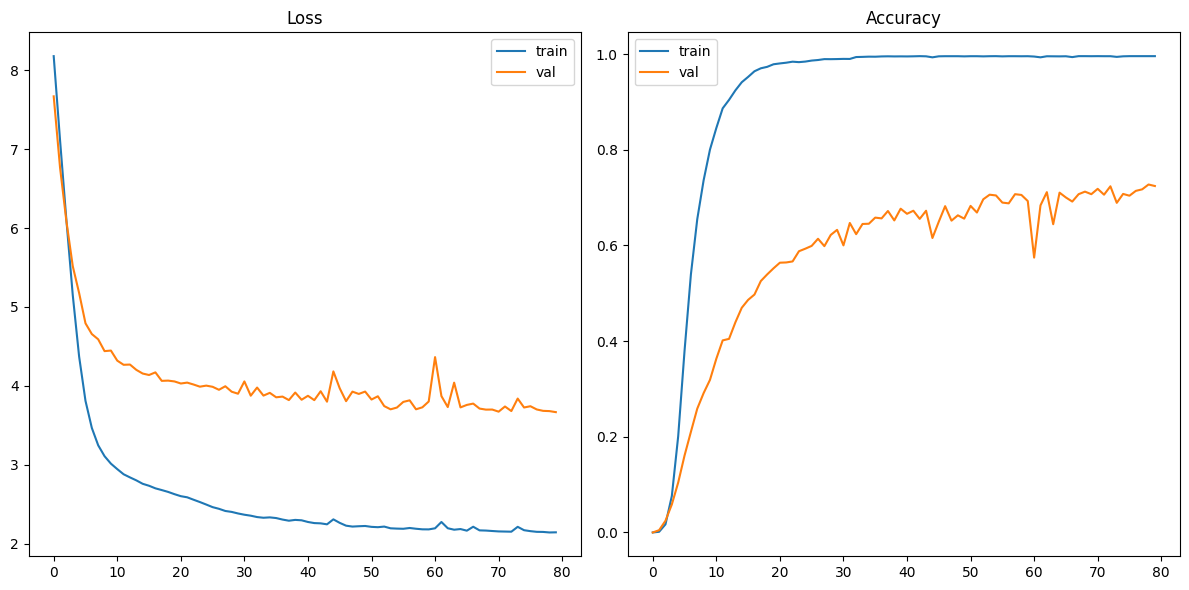

100%|██████████| 80/80 [1:12:55<00:00, 54.69s/it]


In [64]:
loss_train, loss_val, acc_train, acc_val = train_v2(model_v2, criterion, optimizer, epochs, dataloader)

In [25]:
def test_v2(model, dataloader):
    model.eval()
    
    running_corrects = 0
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        with torch.set_grad_enabled(False):
            outputs = model(inputs, labels)
            
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
        
    acc = running_corrects.double() / len(dataloader.dataset)
    
    return acc.item()

In [66]:
test_acc_v2 = test_v2(model_v2, dataloader['test'])
test_acc_v2

0.7136563876651982

In [34]:
query_embeddings_arcface = compute_embeddings(model_v2, query_img_names, './../input/celeba-ir/celebA_ir/celebA_query/')
distractors_embeddings_arcface = compute_embeddings(model_v2, distractors_img_names, './../input/celeba-ir/celebA_ir/celebA_distractors/')

cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, query_embeddings_arcface)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names, query_embeddings_arcface)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings_arcface, distractors_embeddings_arcface)

fprs = [0.5, 0.2, 0.1, 0.05]

for fpr in fprs:
    threshold, tpr = compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=fpr)
    print(f"Threshold = {threshold}, TPR = {tpr}")

Threshold = 0.9763020873069763, TPR = 0.6200665715644318
Threshold = 0.9888600707054138, TPR = 0.31852455675565516
Threshold = 0.9923674464225769, TPR = 0.19190272399972827
Threshold = 0.994344174861908, TPR = 0.11425854221859928


In [67]:
torch.save(model_v2.state_dict(), 'resnet18_celeba_arcface.pt')

# Часть 4

Triplet Loss

Немного переделаем датасет, чтобы он мог возвращать тройки (e, p, n)

In [35]:
class CelebADatasetTriplet(torch.utils.data.Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform
        self.classes = np.unique(self.data['class'])
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        
        pos_class, neg_class = np.random.choice(self.classes, 2)
        
        pos_idx, anchor_idx = np.random.choice(self.data[self.data['class'] == pos_class].index, 2)
        neg_idx = np.random.choice(self.data[self.data['class'] == neg_class].index)
        
        path1, path2, path3 = self.data.loc[anchor_idx, 'path'],  self.data.loc[pos_idx, 'path'], self.data.loc[neg_idx, 'path']
        
        image1 = Image.fromarray(np.array(Image.open(path1))[77:-41, 45:-50])
        image2 = Image.fromarray(np.array(Image.open(path2))[77:-41, 45:-50])
        image3 = Image.fromarray(np.array(Image.open(path3))[77:-41, 45:-50])
        
        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
            image3 = self.transform(image3)
            
        return image1, image2, image3, pos_class

In [36]:
dataloader_triplet = {}

dataset = fetch_data(data_dir + 'celebA_imgs/', split, classes)

train_triplet = CelebADatasetTriplet(dataset[dataset['split'] == 0][['path', 'class']], transform)
val_triplet = CelebADatasetTriplet(dataset[dataset['split'] == 1][['path', 'class']], transform)
test_triplet = CelebADatasetTriplet(dataset[dataset['split'] == 2][['path', 'class']], transform)

dataloader_triplet['train'] = torch.utils.data.DataLoader(train_triplet, batch_size=32, shuffle=True)
dataloader_triplet['val'] = torch.utils.data.DataLoader(val_triplet, batch_size=32, shuffle=True)
dataloader_triplet['test'] = torch.utils.data.DataLoader(test_triplet, batch_size=32, shuffle=True)

100%|██████████| 23948/23948 [00:00<00:00, 49000.93it/s]


In [37]:
def plot_loss_acc_triplet(loss_train, loss_val, acc_val):
    display.clear_output(wait=True)

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(loss_train, label='train')
    plt.plot(loss_val, label='val')
    plt.legend()
    plt.title('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(acc_val, label='val')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

In [38]:
def train_triplet(model, criterion, optimizer, epochs, dataloader, scheduler):
    loss_train = []
    loss_val = []
    
    acc_val = []
    
    for _ in tqdm(range(epochs)):
        train_embeddings = None
        train_labels = None
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            for anchor, positive, negative, label in dataloader[phase]:
                anchor = anchor.to(device)
                positive = positive.to(device)
                negative = negative.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    anchor_outputs = model(anchor)
                    pos_outputs = model(positive)
                    neg_outputs = model(negative)

                    loss = criterion(anchor_outputs, pos_outputs, neg_outputs)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                        if train_labels is None:
                            train_labels = label
                            train_embeddings = anchor_outputs
                        else:
                            train_labels = torch.cat((train_labels, label))
                            train_embeddings = torch.vstack((train_embeddings, anchor_outputs))
                    else:
                        pairwise_sim = pairwise_cosine_similarity(train_embeddings, anchor_outputs)
                        embeddings_idx = torch.argmax(pairwise_sim, dim=0)
                        
                        nearest_labels = train_labels[embeddings_idx.detach().cpu()]
                        
                        running_corrects += torch.sum(nearest_labels == label)
                    
                    running_loss += loss.item() * anchor.size(0)
                    
            epoch_loss = running_loss / len(dataloader[phase].dataset)
            epoch_acc = running_corrects / len(dataloader[phase].dataset)

            if phase == 'train':
                loss_train.append(epoch_loss)
            else:
                loss_val.append(epoch_loss)
                acc_val.append(epoch_acc.item())
                
        scheduler.step()

        plot_loss_acc_triplet(loss_train, loss_val, acc_val)
    
    return loss_train, loss_val, acc_val

В качестве функции расстояния возьмём евклидово расстояние

Также перед Triplet Loss рекомендуется нормировать выходы модели, но у ResNet-а и так BatchNorm перед fc

In [127]:
model_triplet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
model_triplet.fc = nn.Identity()

criterion = torch.nn.TripletMarginLoss(margin=1.0, p=2)
optimizer = torch.optim.AdamW(model_triplet.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

epochs = 50

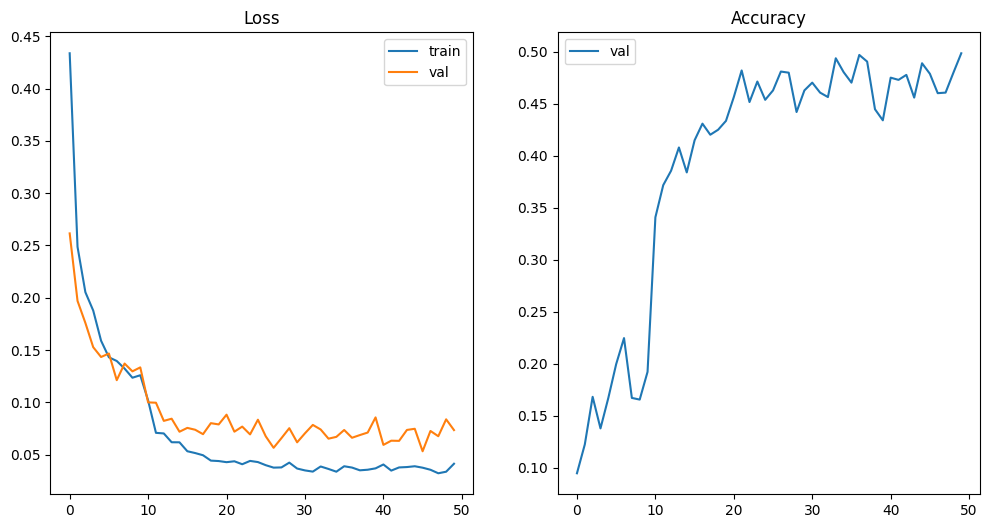

100%|██████████| 50/50 [2:23:08<00:00, 171.78s/it]


In [128]:
_ = train_triplet(model_triplet, criterion, optimizer, epochs, dataloader_triplet, scheduler)

In [130]:
torch.save(model_triplet.state_dict(), 'model_triplet.pt')

In [41]:
def test_triplet(model, dataloader_train, dataloader_test):
    model.eval()
    
    corrects = 0
    train_labels = None
    train_embeddings = None
    
    for anchor, positive, negative, label in dataloader_train:
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        
        with torch.no_grad():
            anchor_outputs = model(anchor)
            pos_outputs = model(positive)
            neg_outputs = model(negative)
        
        if train_labels is None:
            train_labels = label
            train_embeddings = anchor_outputs
        else:
            train_labels = torch.cat((train_labels, label))
            train_embeddings = torch.vstack((train_embeddings, anchor_outputs))
                        
    running_corrects = 0         
    for anchor, positive, negative, label in dataloader_test:
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        
        with torch.no_grad():
            anchor_outputs = model(anchor)
            pos_outputs = model(positive)
            neg_outputs = model(negative)
        
        pairwise_sim = pairwise_cosine_similarity(train_embeddings, anchor_outputs)
        embeddings_idx = torch.argmax(pairwise_sim, dim=0)
                        
        nearest_labels = train_labels[embeddings_idx.detach().cpu()]
                        
        running_corrects += torch.sum(nearest_labels == label)
                    
    acc = running_corrects / len(dataloader_test.dataset)
    
    return acc

In [139]:
test_triplet(model_triplet, dataloader_triplet['train'], dataloader_triplet['test']).item()

0.5292636752128601

In [44]:
query_embeddings_triplet = compute_embeddings(model_triplet, query_img_names, './../input/celeba-ir/celebA_ir/celebA_query/')
distractors_embeddings_triplet = compute_embeddings(model_triplet, distractors_img_names, './../input/celeba-ir/celebA_ir/celebA_distractors/')

cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, query_embeddings_triplet)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names, query_embeddings_triplet)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings_triplet, distractors_embeddings_triplet)

fprs = [0.5, 0.2, 0.1, 0.05]

for fpr in fprs:
    threshold, tpr = compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=fpr)
    print(f"Threshold = {threshold}, TPR = {tpr}")

Threshold = 0.9974693655967712, TPR = 0.6359622308267101
Threshold = 0.9988234043121338, TPR = 0.3350995176958087
Threshold = 0.999215304851532, TPR = 0.2061680592351063
Threshold = 0.9994350075721741, TPR = 0.12770871544052714


Я пробовал разные варианты `margin`, но так ничего лучше этого не получилось

# Часть 5

Исследуем расположение эмбеддингов в случае с Triplet Loss

In [25]:
from sklearn.manifold import TSNE

In [26]:
def get_embeddings(model, dataloader):
    model.eval()
    
    embeddings = []
    labels = []
    
    for anchor, positive, negative, label in dataloader:
        anchor = anchor.to(device)
        
        with torch.no_grad():
            embedding = model(anchor)
            
        embeddings.append(embedding.detach().cpu())
        labels.append(label)
        
    embeddings = np.vstack(embeddings)
    labels = np.hstack(labels)
    
    return embeddings, labels

In [27]:
train_embeddings, train_labels = get_embeddings(model_triplet, dataloader_triplet['train'])
val_embeddings, val_labels = get_embeddings(model_triplet, dataloader_triplet['val'])
test_embeddings, test_labels = get_embeddings(model_triplet, dataloader_triplet['test'])

In [28]:
embeddings = np.vstack((train_embeddings, val_embeddings, test_embeddings))
labels = np.hstack((train_labels, val_labels, test_labels))

In [29]:
def plot_tsne(X_embedded, labels):
    plt.figure(figsize=(12, 6))
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels)
    plt.colorbar()
    plt.show()

In [30]:
tsne = TSNE(n_components=2)

X_embedded = tsne.fit_transform(embeddings)

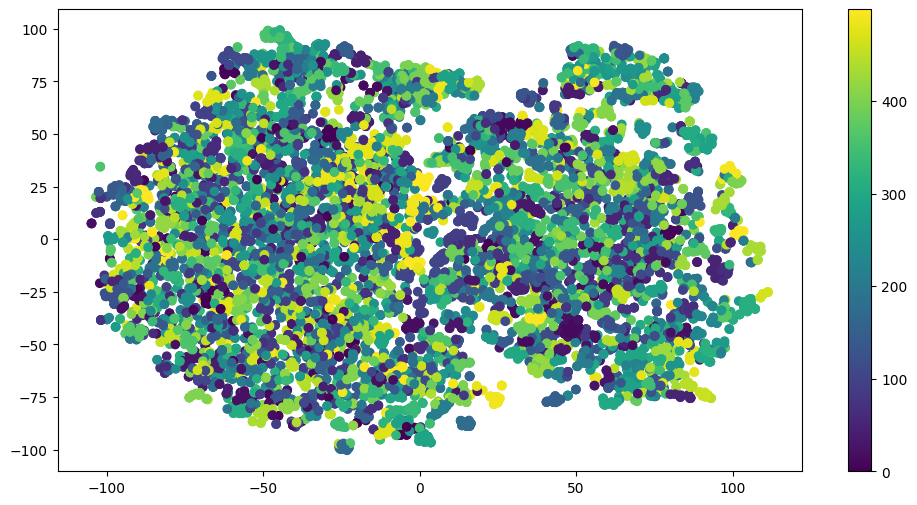

In [31]:
plot_tsne(X_embedded, labels)

ничего не понятно, кроме того, что эмбеддинги многих классов собираются в группы, попробуем оставить 10 классов

In [46]:
chosen_labels = np.arange(0, 10)

cropped_embeddings = embeddings[np.isin(labels, chosen_labels)]
cropped_labels = labels[np.isin(labels, chosen_labels)]

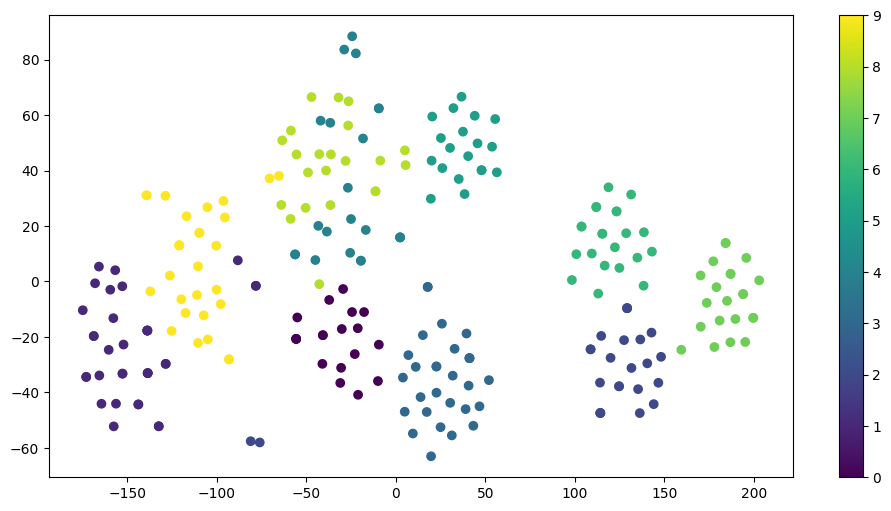

In [47]:
plot_tsne(tsne.fit_transform(cropped_embeddings), cropped_labels)

Тут лучше видно, что эмбеддинги делятся на классы, посмотрим на картинки для класса 9 - они находятся слева, 1 - они около 9 и для 7 - они в правом верхнем углу

In [60]:
t = dataset.loc[dataset['class'].isin([1, 7, 9])].to_numpy()
img7, img9, img1 = t[0], t[1], t[8]
img7[0], img9[0], img1[0]

('./../input/celeba-500/celebA_train_500/celebA_imgs/004806.jpg',
 './../input/celeba-500/celebA_train_500/celebA_imgs/014179.jpg',
 './../input/celeba-500/celebA_train_500/celebA_imgs/120280.jpg')

In [61]:
img1 = np.array(Image.open(img1[0]))
img7 = np.array(Image.open(img7[0]))
img9 = np.array(Image.open(img9[0]))

img1 = Image.fromarray(img1[77:-41, 45:-50])
img7 = Image.fromarray(img7[77:-41, 45:-50])
img9 = Image.fromarray(img9[77:-41, 45:-50])

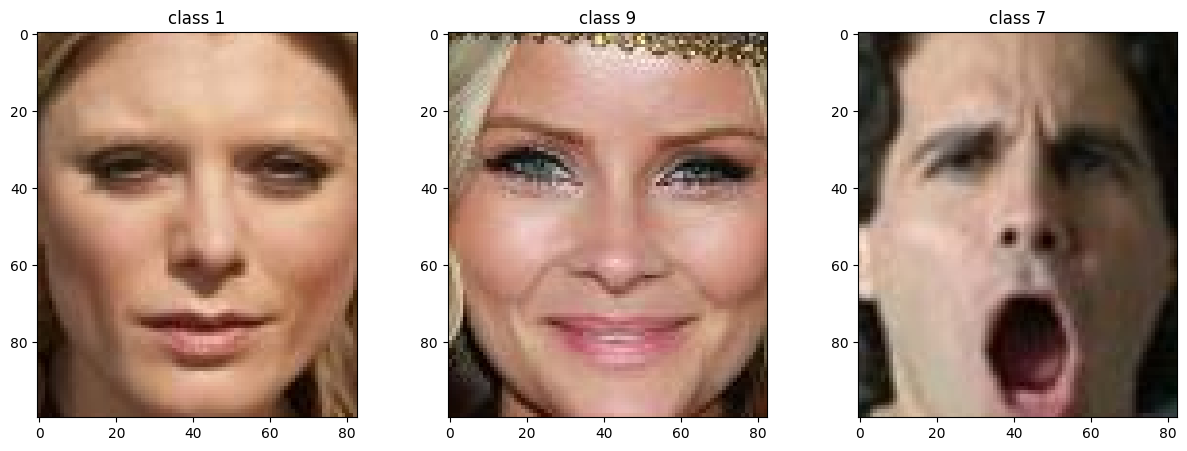

In [64]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.title('class 1')

plt.subplot(1, 3, 3)
plt.imshow(img7)
plt.title('class 7')

plt.subplot(1, 3, 2)
plt.imshow(img9)
plt.title('class 9')

plt.show()

Видим, что класс 1 и класс 9 - это женщины, прямо смотрящие в камеру, а то есть они похоже друг на друга, а 7 - это мужчина, широко открывший рот, поэтому его эмбеддинги далеко

In [65]:
tsne_d3 = TSNE(n_components=3)

X_embedded_d3 = tsne_d3.fit_transform(embeddings)

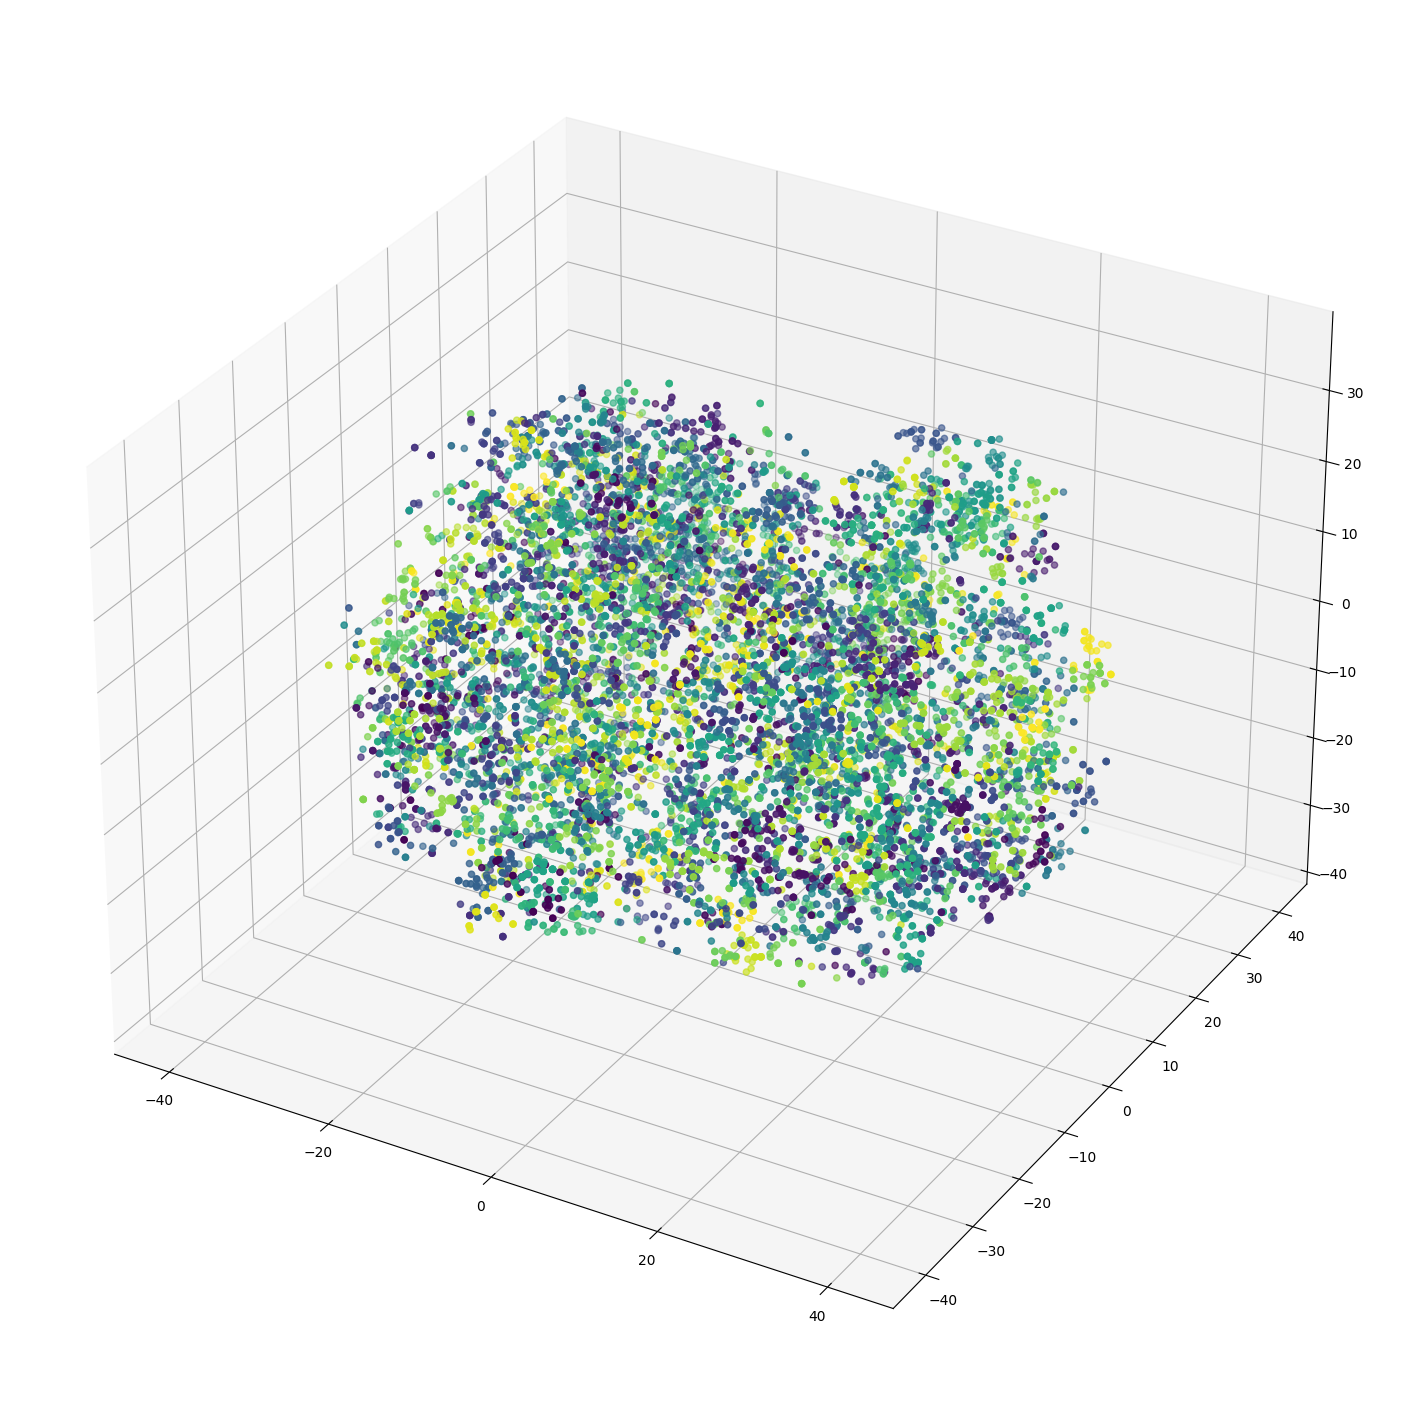

In [67]:
plt.figure(figsize=(18, 18))

ax = plt.axes(projection='3d')
ax.scatter(X_embedded_d3[:, 0], X_embedded_d3[:, 1], X_embedded_d3[:, 2], c=labels)

plt.show()

Тут, в целом, лучше видно, что 

1. есть аутлайеры, которые отделены от своего класса и вообще не находятся в каком либо облаке точек
2. эмбеддинги одного класса часто собираются в группы
3. эмбеддинги разных классов иногда склеиваются в большие облака